In [1]:
#Importing the required modules and general setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleAdiabatic
from galpy.df import quasiisothermaldf
from galpy.util.bovy_coords import *
import sys
sys.path.append('..')

#Importing qdf load data
samples_qdf = np.load('../mock_data/qdf/data/sampleV_at_(0.0,0.0,0.0)_epsilon=0.5_rect.npy')

#Setting up action angle and qdf instances
aA = actionAngleAdiabatic(pot=MWPotential2014,c=True)
qdf = quasiisothermaldf(1./3.,0.2,0.1,1.,1.,pot=MWPotential2014,aA=aA,cutcounter=True)

#convert cylindrical to rectangular
x, y, z = (samples_qdf[:,0], samples_qdf[:,1], samples_qdf[:,2])
vx, vy, vz = (samples_qdf[:,3], samples_qdf[:,4], samples_qdf[:,5])
samples_qdf = np.stack((x, y, z, vx, vy, vz), axis=1)


print('#stars', len(samples_qdf))
print('min/max/mean (x)', min(samples_qdf[:,0]), max(samples_qdf[:,0]), np.mean(samples_qdf[:,0]))
print('min/max/mean (y)', min(samples_qdf[:,1]), max(samples_qdf[:,1]), np.mean(samples_qdf[:,1]))
print('min/max/mean (z)', min(samples_qdf[:,2]), max(samples_qdf[:,2]), np.mean(samples_qdf[:,2]))
print('min/max/mean (vx)', min(samples_qdf[:,3]), max(samples_qdf[:,3]), np.mean(samples_qdf[:,3]))
print('min/max/mean (vy)', min(samples_qdf[:,4]), max(samples_qdf[:,4]), np.mean(samples_qdf[:,4]))
print('min/max/mean (vz)', min(samples_qdf[:,5]), max(samples_qdf[:,5]), np.mean(samples_qdf[:,5]))

c:\users\ayush\anaconda3\lib\site-packages\astropy\coordinates\sky_coordinate.py:1786: AstropyDeprecationWarning: Passing a frame as a positional argument is now deprecated, use the frame= keyword argument instead.
  "instead.", AstropyDeprecationWarning)

#stars 1699708
min/max/mean (x) -8.799609236140716 -7.8009001178134145 -8.28941027928639
min/max/mean (y) -0.49953870661065697 0.4995682614628541 0.002482278453398873
min/max/mean (z) -0.47224099228924643 0.5251864323212104 0.020554162071444157
min/max/mean (vx) -229.1334501573963 225.79860587229317 -0.06492600565603411
min/max/mean (vy) -300.7405372012659 -18.65795773589432 -200.86464268462737
min/max/mean (vz) -78.63184750506196 79.49529776718326 -0.001518106057358567


In [4]:
#Defining a KDE function to quickly compute probabilities for the data set
def generate_KDE(inputs, ker):
    """
    NAME:
        generate_KDE
    
    PURPOSE:
        Given an NxM matrix for inputs and one of six avaliable ker strings, 
        outputs a function `input_DKE` that treats the density estimate as a 
        black box function that can be sampled.
    
    INPUT:
        inputs (ndarray) = An NxM matrix where N is the number of data 
                           points and M is the number of parameters.
        ker (string) = One of the 6 avaliable kernel types (gaussian, 
                       tophat, epanechnikov, exponential, linear, cosine).
    
    OUTPUT:
        input_KDE (function) = A blackbox function for the density estimate
                               used for sampling data.
                               
    HISTORY:
        2018-06-25 - Updated - Ayush Pandhi
    """
    #Scaling velocities with standard deviation
    inputs_std = np.nanstd(inputs, axis=0)
    inputs = inputs/inputs_std
    
    #Optimizing bandwidth in terms of Scott's Rule of Thumb
    shape_string = str(inputs.shape)
    objects, parameters = shape_string.split(', ')
    N_string = objects[1:]
    N = int(N_string)
    IQR = iqr(inputs)
    A = min(np.std(inputs), IQR/1.34)
    bw = 1.059 * A * N ** (-1/5.)
    
    #Fit data points to selected kernel and bandwidth
    kde = KernelDensity(kernel=ker, bandwidth=bw).fit(inputs)  
    
    def input_KDE(samples):
        """
        NAME:
            input_KDE
    
        PURPOSE:
            Given a QxM matrix for samples, evaluates the blackbox density
            estimate function at those points to output a 1xQ array of 
            density values.
    
        INPUT:
            samples (ndarray) = A QxM matrix where Q is the number of points 
                                at which the kde is being evaluated and M is 
                                the number of parameters.
                                
        OUTPUT:
            dens (ndarray) = A 1xQ array of density values for Q data points.
                               
        HISTORY:
            2018-06-25 - Updated - Ayush Pandhi
        """
        #To correct the type of information from other functions into acceptable input
        #samples = np.array([samples])
        
        #Scaling samples with standard deviation
        samples = samples/inputs_std
        
        #Get the log density for selected samples and apply exponential to get normal probabilities
        log_dens = kde.score_samples(samples)
        dens = np.exp(log_dens)
        
        #Return a 1xQ array of normal probabilities for the selected sample
        return dens
    
    #Return a black box function for sampling
    return input_KDE

#Second KDE for 2*Scotts bandwidth
def generate_KDE2(inputs, ker):
    """
    NAME:
        generate_KDE
    
    PURPOSE:
        Given an NxM matrix for inputs and one of six avaliable ker strings, 
        outputs a function `input_DKE` that treats the density estimate as a 
        black box function that can be sampled.
    
    INPUT:
        inputs (ndarray) = An NxM matrix where N is the number of data 
                           points and M is the number of parameters.
        ker (string) = One of the 6 avaliable kernel types (gaussian, 
                       tophat, epanechnikov, exponential, linear, cosine).
    
    OUTPUT:
        input_KDE (function) = A blackbox function for the density estimate
                               used for sampling data.
                               
    HISTORY:
        2018-06-25 - Updated - Ayush Pandhi
    """
    #Scaling velocities with standard deviation
    inputs_std = np.nanstd(inputs, axis=0)
    inputs = inputs/inputs_std
    
    #Optimizing bandwidth in terms of Scott's Rule of Thumb
    shape_string = str(inputs.shape)
    objects, parameters = shape_string.split(', ')
    N_string = objects[1:]
    N = int(N_string)
    IQR = iqr(inputs)
    A = min(np.std(inputs), IQR/1.34)
    bw = 2 * 1.059 * A * N ** (-1/5.)
    
    #Fit data points to selected kernel and bandwidth
    kde = KernelDensity(kernel=ker, bandwidth=bw).fit(inputs)  
    
    def input_KDE2(samples):
        """
        NAME:
            input_KDE
    
        PURPOSE:
            Given a QxM matrix for samples, evaluates the blackbox density
            estimate function at those points to output a 1xQ array of 
            density values.
    
        INPUT:
            samples (ndarray) = A QxM matrix where Q is the number of points 
                                at which the kde is being evaluated and M is 
                                the number of parameters.
                                
        OUTPUT:
            dens (ndarray) = A 1xQ array of density values for Q data points.
                               
        HISTORY:
            2018-06-25 - Updated - Ayush Pandhi
        """
        #To correct the type of information from other functions into acceptable input
        #samples = np.array([samples])
        
        #Scaling samples with standard deviation
        samples = samples/inputs_std
        
        #Get the log density for selected samples and apply exponential to get normal probabilities
        log_dens = kde.score_samples(samples)
        dens = np.exp(log_dens)
        
        #Return a 1xQ array of normal probabilities for the selected sample
        return dens
    
    #Return a black box function for sampling
    return input_KDE2

In [5]:
#Generate kde for 6D qdf inputs
kde_qdf_gaussian = generate_KDE(samples_qdf, 'gaussian')
kde_qdf_tophat = generate_KDE(samples_qdf, 'tophat')
kde_qdf_epanechnikov = generate_KDE(samples_qdf, 'epanechnikov')
kde_qdf_exponential = generate_KDE(samples_qdf, 'exponential')
kde_qdf_linear = generate_KDE(samples_qdf, 'linear')
kde_qdf_cosine = generate_KDE(samples_qdf, 'cosine')

#Generate kde for 2*Scotts bandwidth to compare
kde_qdf_gaussian2 = generate_KDE2(samples_qdf, 'gaussian')
kde_qdf_tophat2 = generate_KDE2(samples_qdf, 'tophat')
kde_qdf_epanechnikov2 = generate_KDE2(samples_qdf, 'epanechnikov')
kde_qdf_exponential2 = generate_KDE2(samples_qdf, 'exponential')
kde_qdf_linear2 = generate_KDE2(samples_qdf, 'linear')
kde_qdf_cosine2 = generate_KDE2(samples_qdf, 'cosine')

In [6]:
#Creating sample points for each parameter changing
N = 1000

#Mean of each parameter as a Nx1 object
mean_x = np.ones((N, 1))*np.mean(samples_qdf[:,0])
mean_y = np.ones((N, 1))*np.mean(samples_qdf[:,1])
mean_z = np.ones((N, 1))*np.mean(samples_qdf[:,2])
mean_vx = np.ones((N, 1))*np.mean(samples_qdf[:,3])
mean_vy = np.ones((N, 1))*np.mean(samples_qdf[:,4])
mean_vz = np.ones((N, 1))*np.mean(samples_qdf[:,5])

#Generating Nx6 sample points for each varying parameter
#For variable x
x_points = np.linspace(min(samples_qdf[:,0]), max(samples_qdf[:,0]), N)
x_points = x_points.reshape(-1, 1)
sample_x = np.hstack((x_points, mean_y, mean_z, mean_vx, mean_vy, mean_vz))

#For variable y
y_points = np.linspace(min(samples_qdf[:,1]), max(samples_qdf[:,1]), N)
y_points = y_points.reshape(-1, 1)
sample_y = np.hstack((mean_x, y_points, mean_z, mean_vx, mean_vy, mean_vz))
                 
#For variable z
z_points = np.linspace(min(samples_qdf[:,2]), max(samples_qdf[:,2]), N)
z_points = z_points.reshape(-1, 1)
sample_z = np.hstack((mean_x, mean_y, z_points, mean_vx, mean_vy, mean_vz))
                 
#For variable vx
vx_points = np.linspace(min(samples_qdf[:,3]), max(samples_qdf[:,3]), N)
vx_points = vx_points.reshape(-1, 1)
sample_vx = np.hstack((mean_x, mean_y, mean_z, vx_points, mean_vy, mean_vz))

#For variable vy
vy_points = np.linspace(min(samples_qdf[:,4]), max(samples_qdf[:,4]), N)
vy_points = vy_points.reshape(-1, 1)
sample_vy = np.hstack((mean_x, mean_y, mean_z, mean_vx, vy_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(min(samples_qdf[:,5]), max(samples_qdf[:,5]), N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_x, mean_y, mean_z, mean_vx, mean_vy, vz_points))

Plots for variable x at, blue = Scotts bw and red = 2*Scotts bw


Text(0.5,1,'Cosine')

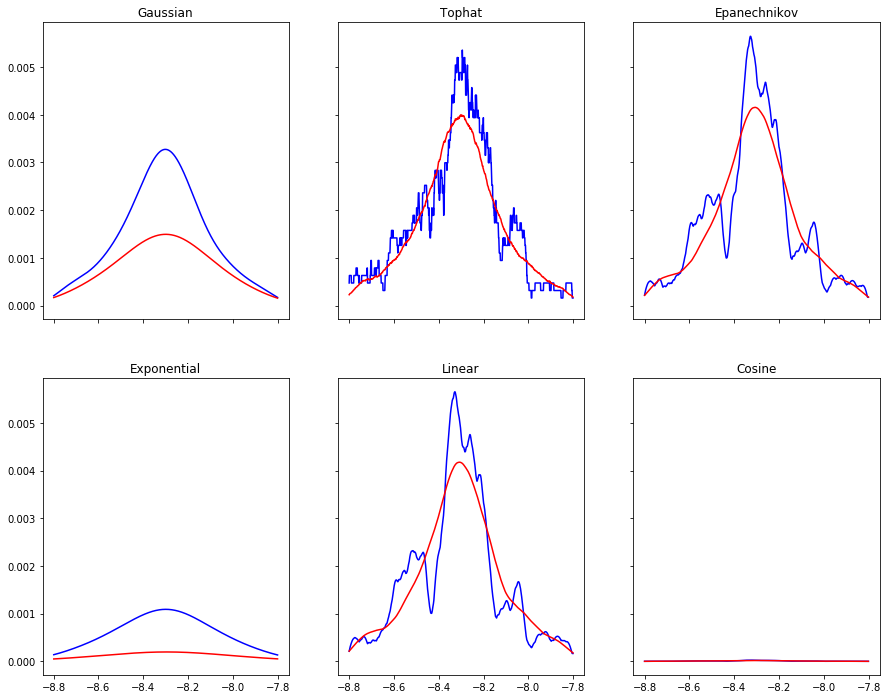

In [7]:
#First set of variable x plots
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 12))
print('Plots for variable x at, blue = Scotts bw and red = 2*Scotts bw')

#Gaussian
xplot_gaussian = kde_qdf_gaussian(sample_x)
xplot_gaussian2 = kde_qdf_gaussian2(sample_x)
ax[0, 0].plot(x_points, xplot_gaussian, 'b-')
ax[0, 0].plot(x_points, xplot_gaussian2, 'r-')
ax[0, 0].set_title("Gaussian")

#Tophat
xplot_tophat = kde_qdf_tophat(sample_x)
xplot_tophat2 = kde_qdf_tophat2(sample_x)
ax[0, 1].plot(x_points, xplot_tophat, 'b-')
ax[0, 1].plot(x_points, xplot_tophat2, 'r-')
ax[0, 1].set_title("Tophat")

#Epanechnikov
xplot_epanechnikov = kde_qdf_epanechnikov(sample_x)
xplot_epanechnikov2 = kde_qdf_epanechnikov2(sample_x)
ax[0, 2].plot(x_points, xplot_epanechnikov, 'b-')
ax[0, 2].plot(x_points, xplot_epanechnikov2, 'r-')
ax[0, 2].set_title("Epanechnikov")

#Exponential
xplot_exponential = kde_qdf_exponential(sample_x)
xplot_exponential2 = kde_qdf_exponential2(sample_x)
ax[1, 0].plot(x_points, xplot_exponential, 'b-')
ax[1, 0].plot(x_points, xplot_exponential2, 'r-')
ax[1, 0].set_title("Exponential")

#Linear
xplot_linear = kde_qdf_linear(sample_x)
xplot_linear2 = kde_qdf_linear2(sample_x)
ax[1, 1].plot(x_points, xplot_linear, 'b-')
ax[1, 1].plot(x_points, xplot_linear2, 'r-')
ax[1, 1].set_title("Linear")

#Cosine
xplot_cosine = kde_qdf_cosine(sample_x)
xplot_cosine2 = kde_qdf_cosine2(sample_x)
ax[1, 2].plot(x_points, xplot_cosine, 'b-')
ax[1, 2].plot(x_points, xplot_cosine2, 'r-')
ax[1, 2].set_title("Cosine")

Plots for variable y at, blue = Scotts bw and red = 2*Scotts bw


Text(0.5,1,'Cosine')

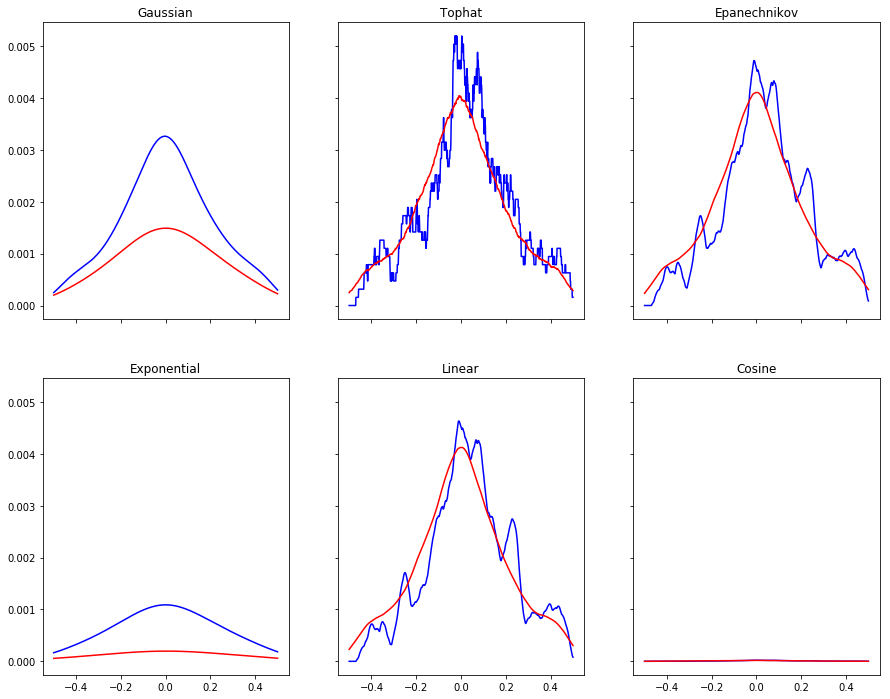

In [8]:
#First set of variable y plots
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 12))
print('Plots for variable y at, blue = Scotts bw and red = 2*Scotts bw')

#Gaussian
yplot_gaussian = kde_qdf_gaussian(sample_y)
yplot_gaussian2 = kde_qdf_gaussian2(sample_y)
ax[0, 0].plot(y_points, yplot_gaussian, 'b-')
ax[0, 0].plot(y_points, yplot_gaussian2, 'r-')
ax[0, 0].set_title("Gaussian")

#Tophat
yplot_tophat = kde_qdf_tophat(sample_y)
yplot_tophat2 = kde_qdf_tophat2(sample_y)
ax[0, 1].plot(y_points, yplot_tophat, 'b-')
ax[0, 1].plot(y_points, yplot_tophat2, 'r-')
ax[0, 1].set_title("Tophat")

#Epanechnikov
yplot_epanechnikov = kde_qdf_epanechnikov(sample_y)
yplot_epanechnikov2 = kde_qdf_epanechnikov2(sample_y)
ax[0, 2].plot(y_points, yplot_epanechnikov, 'b-')
ax[0, 2].plot(y_points, yplot_epanechnikov2, 'r-')
ax[0, 2].set_title("Epanechnikov")

#Exponential
yplot_exponential = kde_qdf_exponential(sample_y)
yplot_exponential2 = kde_qdf_exponential2(sample_y)
ax[1, 0].plot(y_points, yplot_exponential, 'b-')
ax[1, 0].plot(y_points, yplot_exponential2, 'r-')
ax[1, 0].set_title("Exponential")

#Linear
yplot_linear = kde_qdf_linear(sample_y)
yplot_linear2 = kde_qdf_linear2(sample_y)
ax[1, 1].plot(y_points, yplot_linear, 'b-')
ax[1, 1].plot(y_points, yplot_linear2, 'r-')
ax[1, 1].set_title("Linear")

#Cosine
yplot_cosine = kde_qdf_cosine(sample_y)
yplot_cosine2 = kde_qdf_cosine2(sample_y)
ax[1, 2].plot(y_points, yplot_cosine, 'b-')
ax[1, 2].plot(y_points, yplot_cosine2, 'r-')
ax[1, 2].set_title("Cosine")

Plots for variable z at, blue = Scotts bw and red = 2*Scotts bw


Text(0.5,1,'Cosine')

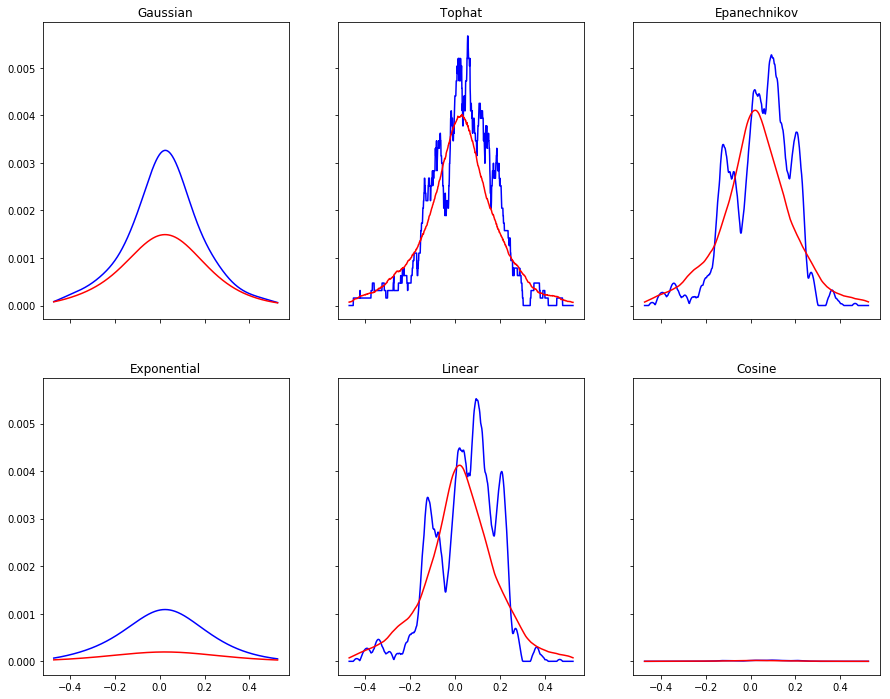

In [9]:
#First set of variable z plots
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 12))
print('Plots for variable z at, blue = Scotts bw and red = 2*Scotts bw')

#Gaussian
zplot_gaussian = kde_qdf_gaussian(sample_z)
zplot_gaussian2 = kde_qdf_gaussian2(sample_z)
ax[0, 0].plot(z_points, zplot_gaussian, 'b-')
ax[0, 0].plot(z_points, zplot_gaussian2, 'r-')
ax[0, 0].set_title("Gaussian")

#Tophat
zplot_tophat = kde_qdf_tophat(sample_z)
zplot_tophat2 = kde_qdf_tophat2(sample_z)
ax[0, 1].plot(z_points, zplot_tophat, 'b-')
ax[0, 1].plot(z_points, zplot_tophat2, 'r-')
ax[0, 1].set_title("Tophat")

#Epanechnikov
zplot_epanechnikov = kde_qdf_epanechnikov(sample_z)
zplot_epanechnikov2 = kde_qdf_epanechnikov2(sample_z)
ax[0, 2].plot(z_points, zplot_epanechnikov, 'b-')
ax[0, 2].plot(z_points, zplot_epanechnikov2, 'r-')
ax[0, 2].set_title("Epanechnikov")

#Exponential
zplot_exponential = kde_qdf_exponential(sample_z)
zplot_exponential2 = kde_qdf_exponential2(sample_z)
ax[1, 0].plot(z_points, zplot_exponential, 'b-')
ax[1, 0].plot(z_points, zplot_exponential2, 'r-')
ax[1, 0].set_title("Exponential")

#Linear
zplot_linear = kde_qdf_linear(sample_z)
zplot_linear2 = kde_qdf_linear2(sample_z)
ax[1, 1].plot(z_points, zplot_linear, 'b-')
ax[1, 1].plot(z_points, zplot_linear2, 'r-')
ax[1, 1].set_title("Linear")

#Cosine
zplot_cosine = kde_qdf_cosine(sample_z)
zplot_cosine2 = kde_qdf_cosine2(sample_z)
ax[1, 2].plot(z_points, zplot_cosine, 'b-')
ax[1, 2].plot(z_points, zplot_cosine2, 'r-')
ax[1, 2].set_title("Cosine")

Plots for variable vx at, blue = Scotts bw and red = 2*Scotts bw


Text(0.5,1,'Cosine')

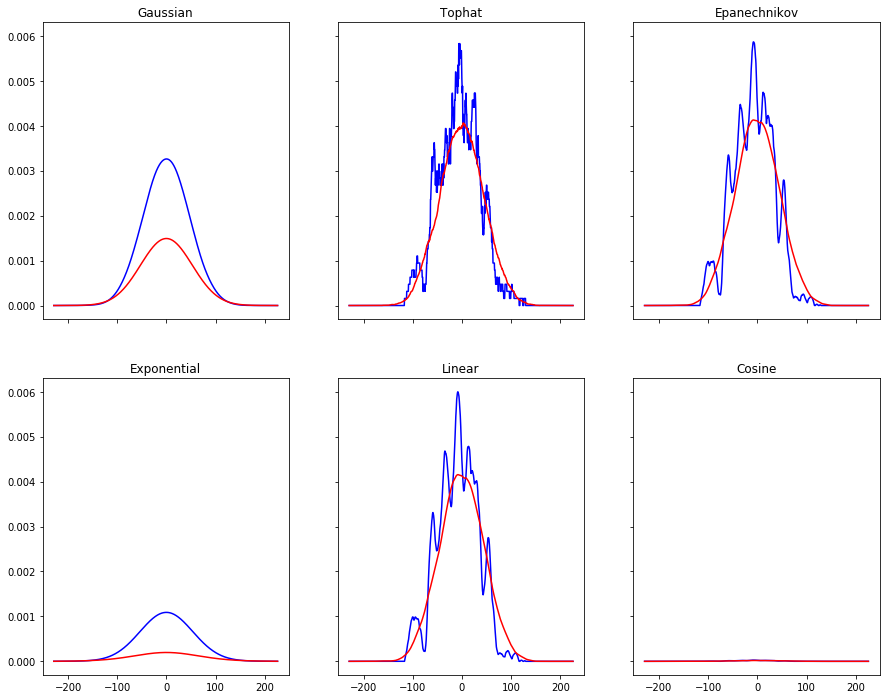

In [10]:
#First set of variable vx plots
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 12))
print('Plots for variable vx at, blue = Scotts bw and red = 2*Scotts bw')

#Gaussian
vxplot_gaussian = kde_qdf_gaussian(sample_vx)
vxplot_gaussian2 = kde_qdf_gaussian2(sample_vx)
ax[0, 0].plot(vx_points, vxplot_gaussian, 'b-')
ax[0, 0].plot(vx_points, vxplot_gaussian2, 'r-')
ax[0, 0].set_title("Gaussian")

#Tophat
vxplot_tophat = kde_qdf_tophat(sample_vx)
vxplot_tophat2 = kde_qdf_tophat2(sample_vx)
ax[0, 1].plot(vx_points, vxplot_tophat, 'b-')
ax[0, 1].plot(vx_points, vxplot_tophat2, 'r-')
ax[0, 1].set_title("Tophat")

#Epanechnikov
vxplot_epanechnikov = kde_qdf_epanechnikov(sample_vx)
vxplot_epanechnikov2 = kde_qdf_epanechnikov2(sample_vx)
ax[0, 2].plot(vx_points, vxplot_epanechnikov, 'b-')
ax[0, 2].plot(vx_points, vxplot_epanechnikov2, 'r-')
ax[0, 2].set_title("Epanechnikov")

#Exponential
vxplot_exponential = kde_qdf_exponential(sample_vx)
vxplot_exponential2 = kde_qdf_exponential2(sample_vx)
ax[1, 0].plot(vx_points, vxplot_exponential, 'b-')
ax[1, 0].plot(vx_points, vxplot_exponential2, 'r-')
ax[1, 0].set_title("Exponential")

#Linear
vxplot_linear = kde_qdf_linear(sample_vx)
vxplot_linear2 = kde_qdf_linear2(sample_vx)
ax[1, 1].plot(vx_points, vxplot_linear, 'b-')
ax[1, 1].plot(vx_points, vxplot_linear2, 'r-')
ax[1, 1].set_title("Linear")

#Cosine
vxplot_cosine = kde_qdf_cosine(sample_vx)
vxplot_cosine2 = kde_qdf_cosine2(sample_vx)
ax[1, 2].plot(vx_points, vxplot_cosine, 'b-')
ax[1, 2].plot(vx_points, vxplot_cosine2, 'r-')
ax[1, 2].set_title("Cosine")

Plots for variable vy at, blue = Scotts bw and red = 2*Scotts bw


Text(0.5,1,'Cosine')

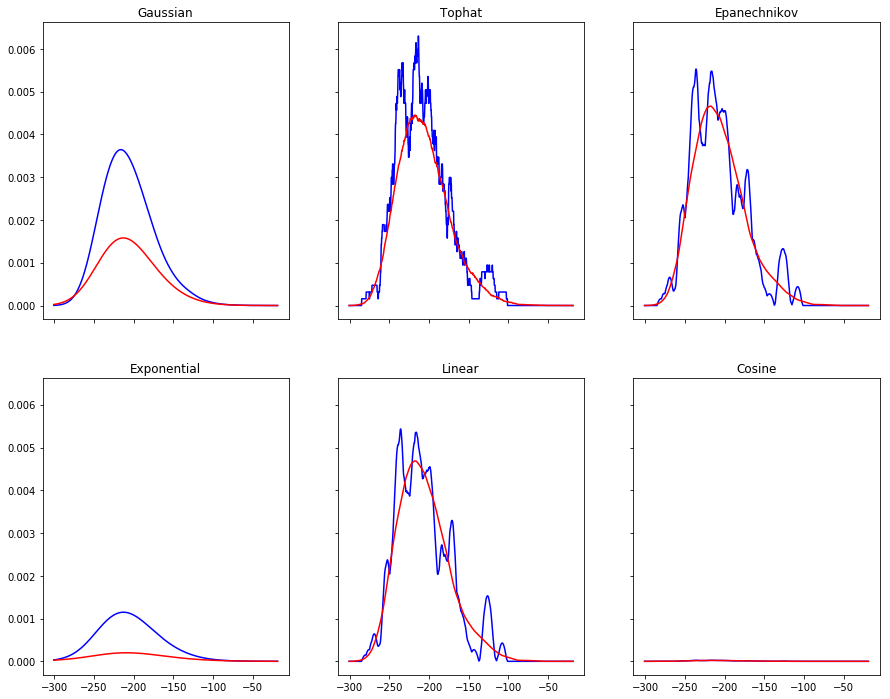

In [11]:
#First set of variable vy plots
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 12))
print('Plots for variable vy at, blue = Scotts bw and red = 2*Scotts bw')

#Gaussian
vyplot_gaussian = kde_qdf_gaussian(sample_vy)
vyplot_gaussian2 = kde_qdf_gaussian2(sample_vy)
ax[0, 0].plot(vy_points, vyplot_gaussian, 'b-')
ax[0, 0].plot(vy_points, vyplot_gaussian2, 'r-')
ax[0, 0].set_title("Gaussian")

#Tophat
vyplot_tophat = kde_qdf_tophat(sample_vy)
vyplot_tophat2 = kde_qdf_tophat2(sample_vy)
ax[0, 1].plot(vy_points, vyplot_tophat, 'b-')
ax[0, 1].plot(vy_points, vyplot_tophat2, 'r-')
ax[0, 1].set_title("Tophat")

#Epanechnikov
vyplot_epanechnikov = kde_qdf_epanechnikov(sample_vy)
vyplot_epanechnikov2 = kde_qdf_epanechnikov2(sample_vy)
ax[0, 2].plot(vy_points, vyplot_epanechnikov, 'b-')
ax[0, 2].plot(vy_points, vyplot_epanechnikov2, 'r-')
ax[0, 2].set_title("Epanechnikov")

#Exponential
vyplot_exponential = kde_qdf_exponential(sample_vy)
vyplot_exponential2 = kde_qdf_exponential2(sample_vy)
ax[1, 0].plot(vy_points, vyplot_exponential, 'b-')
ax[1, 0].plot(vy_points, vyplot_exponential2, 'r-')
ax[1, 0].set_title("Exponential")

#Linear
vyplot_linear = kde_qdf_linear(sample_vy)
vyplot_linear2 = kde_qdf_linear2(sample_vy)
ax[1, 1].plot(vy_points, vyplot_linear, 'b-')
ax[1, 1].plot(vy_points, vyplot_linear2, 'r-')
ax[1, 1].set_title("Linear")

#Cosine
vyplot_cosine = kde_qdf_cosine(sample_vy)
vyplot_cosine2 = kde_qdf_cosine2(sample_vy)
ax[1, 2].plot(vy_points, vyplot_cosine, 'b-')
ax[1, 2].plot(vy_points, vyplot_cosine2, 'r-')
ax[1, 2].set_title("Cosine")

Plots for variable vz at, blue = Scotts bw and red = 2*Scotts bw


Text(0.5,1,'Cosine')

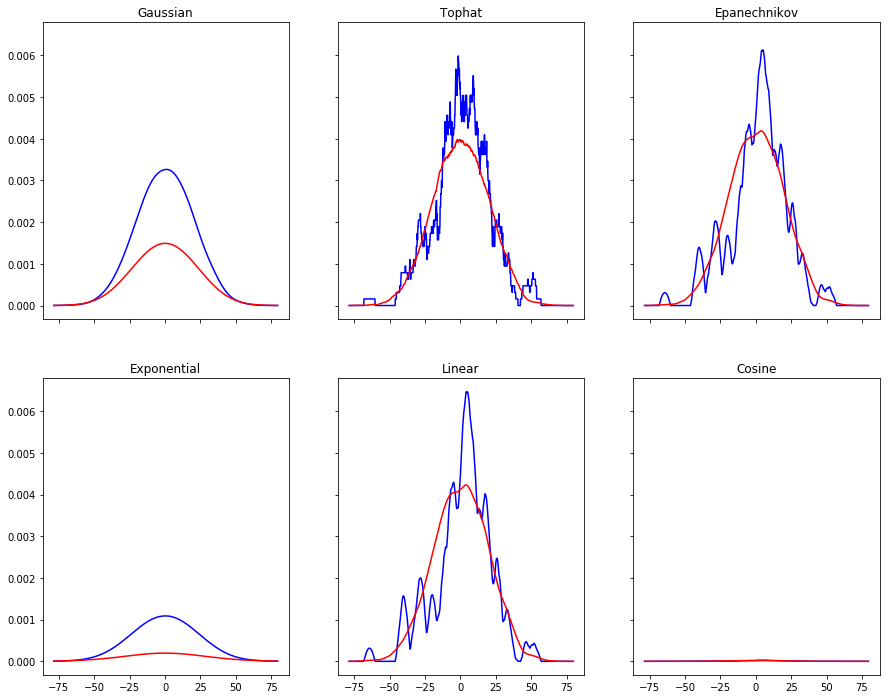

In [12]:
#First set of variable vz plots
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 12))
print('Plots for variable vz at, blue = Scotts bw and red = 2*Scotts bw')

#Gaussian
vzplot_gaussian = kde_qdf_gaussian(sample_vz)
vzplot_gaussian2 = kde_qdf_gaussian2(sample_vz)
ax[0, 0].plot(vz_points, vzplot_gaussian, 'b-')
ax[0, 0].plot(vz_points, vzplot_gaussian2, 'r-')
ax[0, 0].set_title("Gaussian")

#Tophat
vzplot_tophat = kde_qdf_tophat(sample_vz)
vzplot_tophat2 = kde_qdf_tophat2(sample_vz)
ax[0, 1].plot(vz_points, vzplot_tophat, 'b-')
ax[0, 1].plot(vz_points, vzplot_tophat2, 'r-')
ax[0, 1].set_title("Tophat")

#Epanechnikov
vzplot_epanechnikov = kde_qdf_epanechnikov(sample_vz)
vzplot_epanechnikov2 = kde_qdf_epanechnikov2(sample_vz)
ax[0, 2].plot(vz_points, vzplot_epanechnikov, 'b-')
ax[0, 2].plot(vz_points, vzplot_epanechnikov2, 'r-')
ax[0, 2].set_title("Epanechnikov")

#Exponential
vzplot_exponential = kde_qdf_exponential(sample_vz)
vzplot_exponential2 = kde_qdf_exponential2(sample_vz)
ax[1, 0].plot(vz_points, vzplot_exponential, 'b-')
ax[1, 0].plot(vz_points, vzplot_exponential2, 'r-')
ax[1, 0].set_title("Exponential")

#Linear
vzplot_linear = kde_qdf_linear(sample_vz)
vzplot_linear2 = kde_qdf_linear2(sample_vz)
ax[1, 1].plot(vz_points, vzplot_linear, 'b-')
ax[1, 1].plot(vz_points, vzplot_linear2, 'r-')
ax[1, 1].set_title("Linear")

#Cosine
vzplot_cosine = kde_qdf_cosine(sample_vz)
vzplot_cosine2 = kde_qdf_cosine2(sample_vz)
ax[1, 2].plot(vz_points, vzplot_cosine, 'b-')
ax[1, 2].plot(vz_points, vzplot_cosine2, 'r-')
ax[1, 2].set_title("Cosine")